# Analyze Customer Reviews  using IBM Watson Natural Language Understanding

#### Author: Swami Chandrasekaran
In this notebook we will analyze the [Customer Complaints](https://catalog.data.gov/dataset/consumer-complaint-database#topic=consumer_navigation) dataset from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database#topic=consumer_navigation) using Watson Natural Language Understanding (NLU). The data set contains both unstructured and structured fields. Specifically we will enrich the unstructured text columnn using Watson NLU for Entities, Keywords, and Document Sentiment. Using these Watson NLU provided additional features, we will analyze, and visualize the results to answer a few key questions. Watson NLU is one of the API's on the Watson Developer Cloud platform that let's you analyze text to extract meta-data from content such as concepts, entities, keywords, categories, sentiment, emotion, relations, semantic roles, using natural language understanding.

In this notebook, we'll load the Customer Complaints dataset in CSV format using Pandas and do some basic descriptive analysis. We will then enrich the columns in the dataset using Watson Natural Language Understanding to get the sentiment, document emotion, and keywords. We will then perform additonal descriptive analysis on the enriched dataset to understand the relationships between various columns/features. For example, the emotion expressed by the customer via his/her, the relationship between sentiment score and a product of a given complaint etc.

_NOTE: For more details about the fields in the dataset, visit [here](https://cfpb.github.io/api/ccdb/fields.html)._

Familiarity with Python 3.6 is __stongly__ recommended including Pandas to understand & run this Notebook. For the purposes of this notebook, we will use three (3) visualization libraries,
1. [matplotlib](https://matplotlib.org/) - a plotting library for the Python and its numerical mathematics extension NumPy
1. [Plotly](https://plot.ly/python/) - an interactive, browser-based graphing library for Python.
1. [Seaborn](https://seaborn.pydata.org/) - a Python visualization library based on matplotlib.

The goal is to show the art of the possible with each one of these when trying to visualize the Watson enriched dataset. This notebook contains code to get you started with visualizing data with all these libraries.

<a id="toc"></a>
### Table of Contents
This notebook has the following sections:
0. [Data & Questions](#data)
1. [Setup](#setup)
1. [Load the data](#data_set)
1. [Prepare the data](#prepare)
1. [Visualize the data](#visualize)
1. [Enrich the data using Watson NLU](#enrich_data_set)
1. [Visualize the enriched data](#enrich_visualize)
1. [Summary and next steps](#summary)

<a id="data"></a>
## 0. Data & Questions

The "Consumer Complaint Database" from from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database#topic=consumer_navigation) are complaints that were received by Consumer Financial Protection Bureau about financial products and services. The dataset is made available in a CSV format and has the following characteristics,
- Number of rows = 957663
- Number of columns = 18
- Columns: 'Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', _'Consumer complaint narrative*'_, 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer','Timely response?', 'Consumer disputed?'

### The Questions
Let's go out and try to find the answers and insights to the following questions,
1. What is the distribution count of sentiment polarity (negative, neutral, positive) overall?
1. What is the histogram of sentiment scores?
1. How do the sentiment values trend over the years?
1. How does the sentiment vary by the day of the week?
1. Which is the predominant emotion detected from the text by year?
1. Which words are used when the customers are angry or disgusted?
1. What type of emotions are expressed by product & sub-product?
1. What is the relationship between the Product, Sub-Product and the Sentiment score?
1. What is the distribution of sentiment type and emotion by month across all years?
1. Which companies had the highest negative sentiment scores?
1. How are the columns/features correlated?

<a id="setup"></a>
## 1. Setup

### 1.1 Install Latest Watson Developer Cloud and other packages if you have not installed them previously.

In [33]:
# Please comment / uncomment out and install the right set of modules / libraries that you may need. 
# Be sure all of your imports work properly before proceeding any further.

# Install the Watson Developer Cloud Python SDK. This is a one time activity.
!pip install --upgrade watson-developer-cloud

# Install Plotly graphing library
!pip install plotly --upgrade
!pip install cufflinks

# Install wordcloud
!pip install wordcloud 

# Install Seaborn
!pip install seaborn

The directory '/Users/swamchan/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/swamchan/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 174kB 2.3MB/s ta 0:00:01
Requirement already up-to-date: requests<3.0,>=2.0 in /Users/swamchan/.local/lib/python3.6/site-packages (from watson-developer-cloud)
Requirement already up-to-date: python_dateutil>=2.5.3 in /Users/swamchan/anaconda/lib/python3.6/site-packages (from watson-developer-cloud)
Requirement already up-to-date: autobahn>=0.10.9 in /Users/swamchan/anaconda/lib/python3.6/site-packages (from watson-developer-cloud)
Requi

The directory '/Users/swamchan/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/swamchan/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/swamchan/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/swamchan/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo,

### 1.2 Restart Kernel
>Required after installs/upgrades only.

If any libraries were just installed or upgraded, restart the kernel before continuing. After this has been done once, you might want to comment out the !pip install lines above for cleaner output and a faster "Run All".

### 1.3  Import Packages and Libraries

In [2]:
import datetime
import json
import numpy as np
import operator
import pandas as pd
import random
import requests
import string
import sys
from os.path import join, dirname
from pandas_datareader import data as web
from datetime import datetime as dt
from dateutil.parser import parse
from io import StringIO
from functools import reduce
from __future__ import print_function
from wordcloud import WordCloud, STOPWORDS

# Import the packages including the Watson Developer Cloud Python SDK libs
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, EmotionOptions, SentimentOptions

# Import all the visualization libs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
matplotlib.style.use('seaborn-pastel')

import seaborn as sns
import cufflinks as cf
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

### 1.4 Add Service Credentials for Watson Services
Edit the following cell to provide your credentials of your Watson Natural Language Understanding instance.

In [3]:
# Replace with your Watson NLU instance credentials
WATSON_NLU_USERNAME = 'YOUR WATSON NLU USERID'
WATSON_NLU_PASSWORD = 'YOUR WATSON NLU PASSWORD'

In [4]:
# Create connections to the Watson services using the client SDK
nlu = NaturalLanguageUnderstandingV1(version='2017-02-27', username=WATSON_NLU_USERNAME, password=WATSON_NLU_PASSWORD)

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="data_set"></a>
## 2. Load the data 
The "customer complaints" data set is available from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database#topic=consumer_navigation). Go to the <a href="https://catalog.data.gov/dataset/consumer-complaint-database#topic=consumer_navigation" target="_blank">Consumer Complaint Database</a> to download the dataset that is made available in CSV format.

In [5]:
CUST_COMP_CSV_DIR = "../data/"
CUST_COMP_CSV_FILE = "Consumer_Complaints.csv"

### 2.1 Read the CSV File

In [6]:
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
df_cust_comp_orig = pd.read_csv(CUST_COMP_CSV_DIR + CUST_COMP_CSV_FILE)

print('Successfully read the CSV file ....')
#df_data_fake_orig.head(2)

Successfully read the CSV file ....


In [7]:
df_cust_comp_orig.shape

(957663, 18)

### 2.2 Describe and Visualize the data

In [8]:
print('Number of rows in the dataset: ', df_cust_comp_orig.shape[0])
print('Number of columns in the dataset: ', df_cust_comp_orig.shape[1])
print('Following are the list of column type organized using groupby:', df_cust_comp_orig.columns.to_series().groupby(df_cust_comp_orig.dtypes).groups)

Number of rows in the dataset:  957663
Number of columns in the dataset:  18
Following are the list of column type organized using groupby: {dtype('int64'): Index(['Complaint ID'], dtype='object'), dtype('O'): Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?'],
      dtype='object')}


### 2.3 Clean up the data a bit
For the purposes of this notebook and analysis, let's drop all rows that have a blank column value. I would __not recommend__ you do this when do a full data analysis. But again this step is for the purposes of the notebook.

In [9]:
df_cust_comp_cleaned = df_cust_comp_orig.dropna(how='any', axis=0) 

In [10]:
df_cust_comp_cleaned.shape

(3105, 18)

### 2.3 Pick 250 rows
With the Lite or Free plan, you are entitled to 30,000 NLU Item calls Per Month. A NLU item is based on the number of data units enriched and the number of enrichment features applied. A data unit is 10,000 characters or less. For example: extracting Entities and Sentiment from 15,000 characters of text is (2 Data Units * 2 Enrichment Features) = 4 NLU Items.

So let's random pick 250 records from the data frame. If you can upgrade to the higher plan or can run, please go ahead and run the entire data set.

In [11]:
__NUMBER_OF_CSV_RECORDS_TO_READ = 250

In [12]:
df_cust_comp_cleaned_250 = df_cust_comp_cleaned.sample(n=__NUMBER_OF_CSV_RECORDS_TO_READ)

random_rows = np.random.choice(df_cust_comp_cleaned_250.index.values, __NUMBER_OF_CSV_RECORDS_TO_READ)
df_cust_comp_cleaned_250 = df_cust_comp_cleaned_250.ix[random_rows]

In [13]:
df_cust_comp_cleaned_250.shape

(250, 18)

In [14]:
df = df_cust_comp_cleaned_250

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="enrich_data_set"></a>
## 3. Enrich the data using Watson NLU
Now let's enrich the __"Consumer complaint narrative"__ column from the data set using Watson Natural Language Understanding. We will enrich for getting the following,
- Sentiment
- Emotion
- Entities
- Keywords
 
See detailed API documentation for the Watson NLU API at __[Watson NLU API Reference](https://www.ibm.com/watson/developercloud/natural-language-understanding/api/v1/)__.

### 3.1 Enrich __"Consumer complaint narrative"__ and add the additional columns to the dataframe

In [30]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), 
                    keywords=KeywordsOptions(), 
                    emotion=EmotionOptions(), 
                    sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Simple counter to track NLU usage
usage = 0

# Go through every response and enrich the text using NLU.
for text in df['Consumer complaint narrative']:
    # We are assuming English to avoid errors when the language cannot be detected.
    enriched_json = nlu.analyze(text=text, features=features, language='en')

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('0')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('0')
    else:
        overallSentimentScore.append('0')
        overallSentimentType.append('0')

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])
    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else:
        kywords.append("")
            
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']: 
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
 
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")
    
    # Get the usage information for the request
    if 'usage' in enriched_json:
        usage = usage + int(enriched_json["usage"]["text_units"])
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['TextOverallSentimentScore'] = overallSentimentScore

df['TextKeywords'] = kywords
df['TextEntities'] = entities

print('Successfully enriched the dataframe using Watson NLU. Usage was ' + str(usage) + " text units (Number of 10,000-character units processed)")

Successfully enriched the dataframe using Watson NLU. Usage was 500 text units (Number of 10,000-character units processed)


### 3.2 Consolidate and add a few more columns
After we extract all of the Keywords and Entities from enriching __Consumer complaint narrative__, we have columns with multiple Keywords and Entities separated by commas. Now lets add two new columns to the datadrame capture the MaxTextKeyword and MaxTextEntity.

In [ ]:
# Choose first of Keywords,Concepts, Entities
df["MaxTextKeywords"] = df["TextKeywords"].apply(lambda x: x.split(',')[0])
df["MaxTextEntity"] = df["TextEntities"].apply(lambda x: x.split(',')[0])


# Convert the 'Date received' column that is in string format to datetime format.
# Will be very useful for performing data specific operations and grouping
df['Date received N'] = pd.to_datetime(df['Date received'])

# Add a column to specify the day of the week, month of the year and year
df['Date received DoW'] = pd.to_datetime(df['Date received']).dt.weekday_name
df['Date received MoY'] = pd.to_datetime(df['Date received']).dt.strftime("%B")
df['Date received Qr'] = pd.to_datetime(df['Date received']).dt.quarter
df['Date received Yr'] = pd.to_datetime(df['Date received']).dt.year

### 3.3 Enrichment Completed
Save a copy of the enriched DataFrame to a CSV file

In [32]:
# Build the enriched file name from the original filename.
localfilename = CUST_COMP_CSV_DIR + 'enriched_' + datetime.date.today().strftime("%B_%d_%Y") + "_" + CUST_COMP_CSV_FILE

# Write a CSV file from the enriched pandas DataFrame.
df.to_csv(localfilename, sep=',', index = False, )

In [16]:
#root_dir = '/Users/swamchan/Documents/Work/OTHERS/Books.Articles/Packt-Watson/Part-I/Section 4/data/'
#root_file = 'enriched_March_14_2018_Consumer_Complaints.csv'

#df = pd.read_csv(root_dir+root_file)

In [17]:
df.head(1)

Date received       Product               Sub-product                Issue  \
0    05/04/2016  Student loan  Non-federal student loan  Can't repay my loan   

                             Sub-issue  \
0  Can't temporarily postpone payments   

                        Consumer complaint narrative  \
0  This is about XXXX and Great LakesXXXX I have ...   

                             Company public response      Company State  \
0  Company believes it acted appropriately as aut...  GREAT LAKES    MD   

  ZIP code        ...        TextOverallSentimentScore  \
0    207XX        ...                        -0.316393   

                                        TextKeywords  \
0  XXXX, XXXX XXXX, credit, payments, timely paym...   

                             TextEntities MaxTextKeywords MaxTextEntity  \
0  Quantity, Quantity, Quantity, Quantity            XXXX      Quantity   

  Date received N Date received DoW  Date received MoY Date received Qr  \
0      2016-05-04         Wednesday                May                2   

   Date received Yr  
0              2016  

[1 rows x 31 columns]

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="visualize"></a>
## 4. Visualize the data
Now that we have enriched the dataset using Watson, let's analyze the data via visualizations. Here are some of the interesting questions for which we would like to see answers and knowledge all leading to actionable insights.
1. What is the distribution count of sentiment polarity (negative, neutral, positive) overall?
1. How do the sentiment values trend over the years?
1. How does the sentiment vary by the day of the week?
1. Which keywords are use when the customers are angry or disgusted?¶
1. What type of emotions are expressed by product & sub-product?
1. What type of emotions are expressed by product & sub-product?
1. What is the relationship between the Sub-Product and the Sentiment score?

1. Which companies had the most negative sentiment complaints?
1. What is the distribution of sentiment type and emotion by month across all years?
1. Which words or phrases are the most used?
1. 

We will use [Matplotlib](https://matplotlib.org/) and [Plotly](https://plot.ly/python/) to create charts and visualizations.

### What is the distribution count of sentiment polarity (negative, neutral, positive) overall?

In [18]:
neg = len(df[df["TextOverallSentimentType"] == "negative"])
pos = len(df[df["TextOverallSentimentType"] == "positive"])
neut = len(df[df["TextOverallSentimentType"] == "neutral"])
sent_dist = [
    Bar(
        x=["negative","neutral","positive"],
        y=[neg, neut, pos],
        text=['Count of Negative Sentiment', 'Count of Neutral Sentiment', 'Count of Positive Sentiment'],
        marker=dict(
            color = ['#E53935','#FFEE58','#66BB6A'],
            line = dict(color='#BDBDBD', width=1.5,
        )
    ),
    opacity=0.75
)]
py.offline.iplot({"data":sent_dist, "layout":graph_objs.Layout(title="Sentiment Type Distribution in Complaints")})

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### What is the histogram of sentiment scores?
A histogram is a plot lets you see the underlying frequency distribution of the sentiment scores.

In [19]:
data = [Histogram(x=df['TextOverallSentimentScore'])]
layout = Layout(
    title="Histogram of Sentiment Scores Frequency Counts"
)
fig = Figure(data=data, layout=layout)

url = iplot(fig, filename='pandas/simple-histogram')

### How do the sentiment values trend over the years?

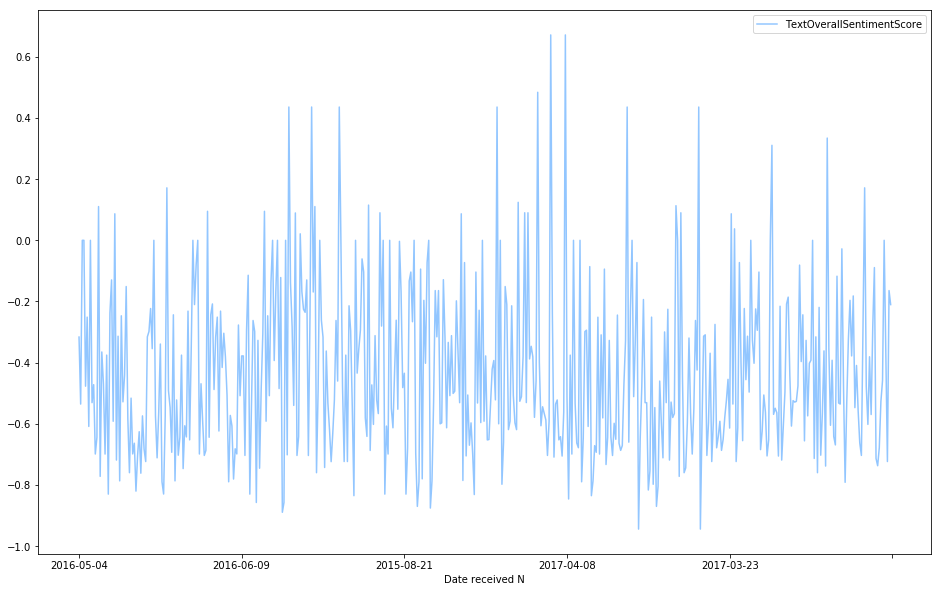

In [20]:
df[['Date received N','TextOverallSentimentScore']].set_index('Date received N').plot(figsize=(16,10))

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### How does the sentiment vary by the day of the week?
Box plots shows the three quartile values of the sentiment score distribution along with extreme values. The “whiskers” extend to points that lie within 1.5 IQRs of the lower and upper quartile, and then observations that fall outside this range are displayed independently. Importantly, this means that each value in the boxplot corresponds to an actual observation in the data.

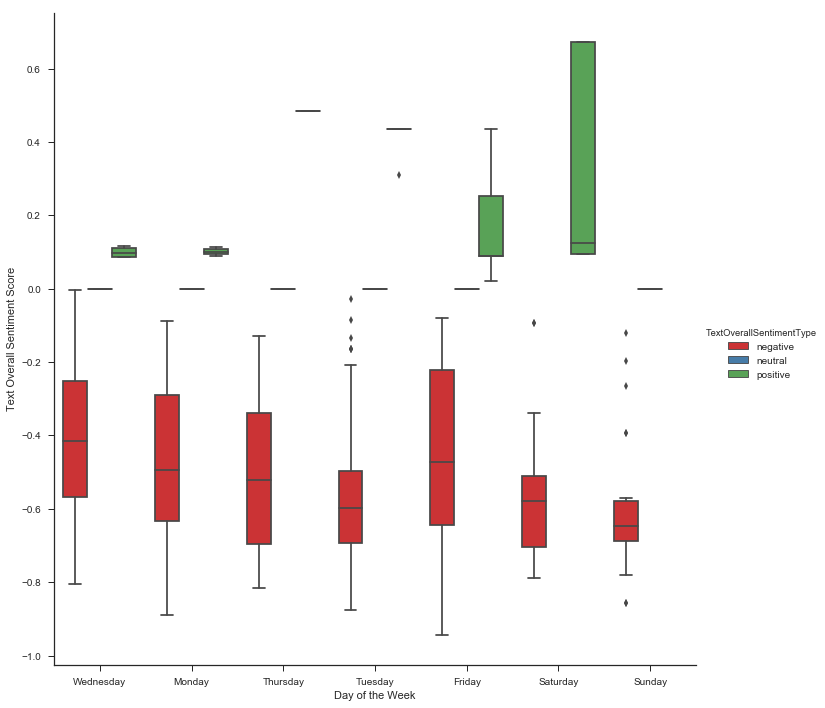

In [21]:
sns.set(style="whitegrid")

with sns.axes_style(style='ticks'):
    g = sns.factorplot("Date received DoW", "TextOverallSentimentScore", "TextOverallSentimentType", data=df, 
                       kind="box", palette="Set1", size=10)
    #g.suptitle("Sentment by Day of the Week");
    g.set_axis_labels("Day of the Week", "Text Overall Sentiment Score");

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### Which is the predominant emotion detected from the text by year?

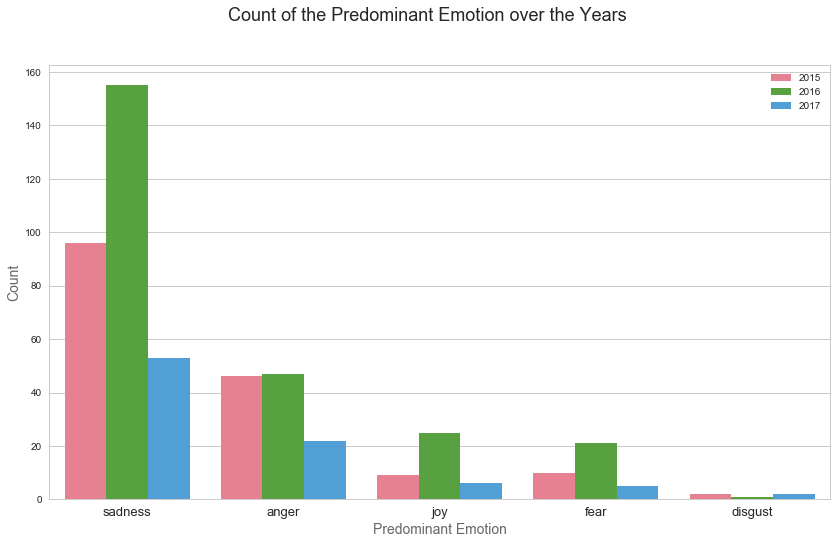

In [22]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 8)

sns.countplot(x=df["TextHighestEmotion"], hue=df["Date received Yr"], data=df, palette="husl");

# set the chart title, size and axis labels
fig.set_size_inches(14, 8)
fig.suptitle('Count of the Predominant Emotion over the Years', fontsize=18)
ax.set_xlabel("Predominant Emotion", size=14, alpha=0.7)
ax.set_ylabel("Count", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=13)
plt.legend(loc='upper right')

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### Which words are used when the customers are angry or disgusted?
> We will use the word_cloud package. https://github.com/amueller/word_cloud

(-0.5, 799.5, 399.5, -0.5)

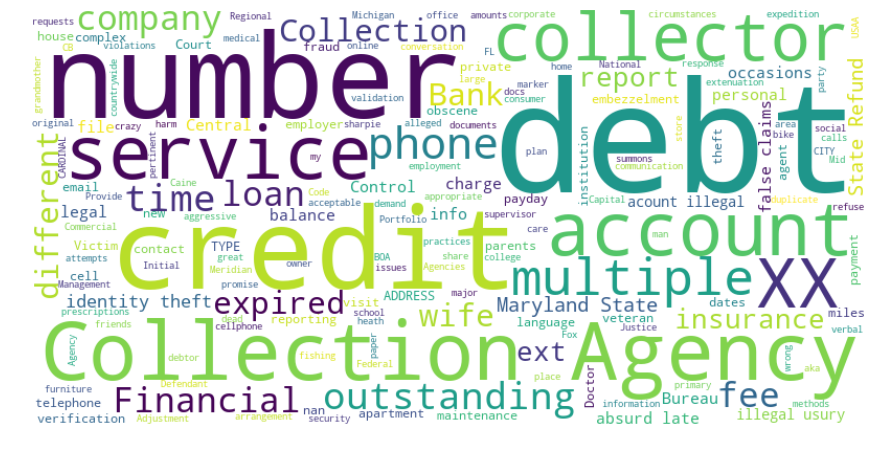

In [23]:
# get only angry & disgust emotion type
df_anger_disgust = df.loc[(df['TextHighestEmotion'] == 'anger') | (df['TextHighestEmotion'] == 'disgust')]

stopwords = ["Hello", "Hi","hello","hi","thanks","ok","XXXX XXXX XXXX", "XXXX XXXX", "XXXX"]

# Generate a word cloud image
text = df_anger_disgust['TextKeywords']
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(' '.join(str(v) for v in df_anger_disgust['TextKeywords']))
fig, ax = plt.subplots()
plt.imshow(wordcloud, interpolation='bilinear')
fig.set_size_inches(15, 9)
plt.axis("off")

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### What type of emotions are expressed by product & sub-product?

In [24]:
groupby_product_emotion = df['TextHighestEmotion'].groupby([df['Product'], df['Sub-product']])
groupby_product_emotion

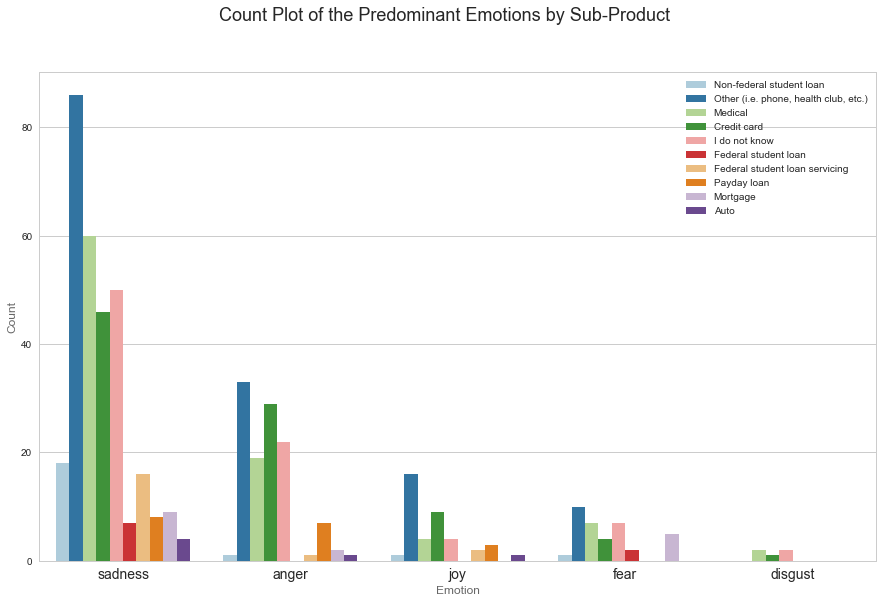

In [25]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()

sns.countplot(x=df["TextHighestEmotion"], data=df, hue=df["Sub-product"], palette="Paired");

# set the chart title, size and axis labels
fig.set_size_inches(15, 9)
fig.suptitle('Count Plot of the Predominant Emotions by Sub-Product', fontsize=18)
ax.set_xlabel("Emotion", size=12, alpha=0.7)
ax.set_ylabel("Count", size=12, alpha=0.7)
plt.xticks(rotation=0, fontsize=14)
plt.legend(loc='upper right')

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### What is the relationship between the Product, Sub-Product and the Sentiment score?
> - __A Violin Plot__ is used to visualise the distribution of the data and its probability density.
> - They are similar to box plots, except that they also show the probability density of the data at different values.
> - This chart shows the distribution shape of the data. 
> - The thick black bar in the centre represents the interquartile range, the thin black line extended from it represents the 95% confidence intervals, and the white dot is the median.
> - Extremely skinny shape on each end and wide in the middle indicates the sentiment scores are highly concentrated around the median.

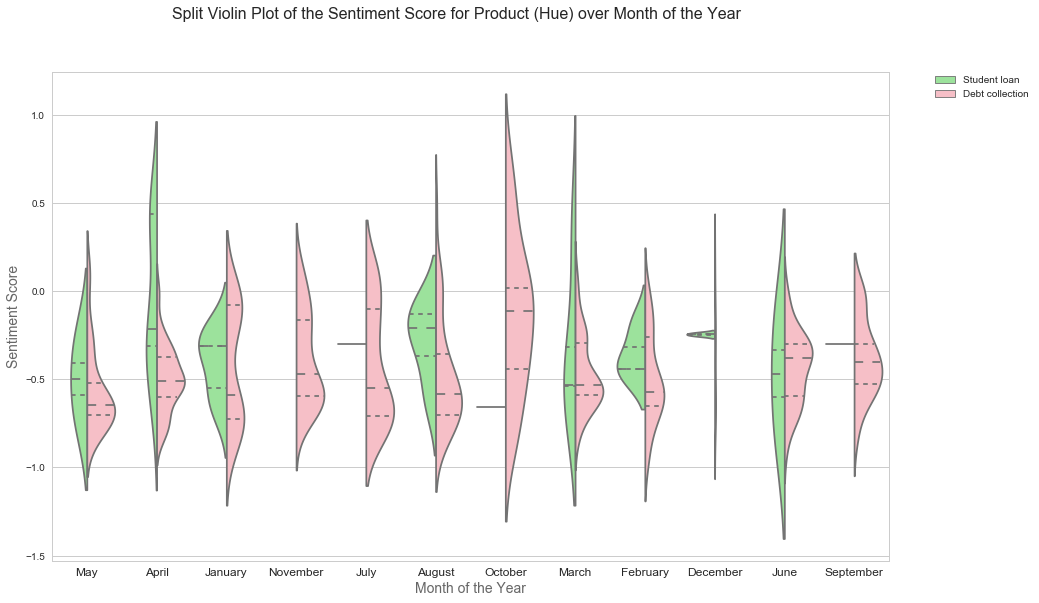

In [26]:
pos = (df['TextOverallSentimentType'] == 'positive')
neg = (df['TextOverallSentimentType'] == 'negative')
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

with sns.axes_style(style=None):
    sns.violinplot("Date received MoY", "TextOverallSentimentScore", hue="Product", data=df,
                   split=True, inner="quartile",
                   palette=["lightgreen", "lightpink"]);
    
# set the chart title, size and axis labels
f.set_size_inches(15, 9)
f.suptitle('Split Violin Plot of the Sentiment Score for Product (Hue) over Month of the Year', fontsize=16)
ax.set_xlabel("Month of the Year", size=14, alpha=0.7)
ax.set_ylabel("Sentiment Score", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=12)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

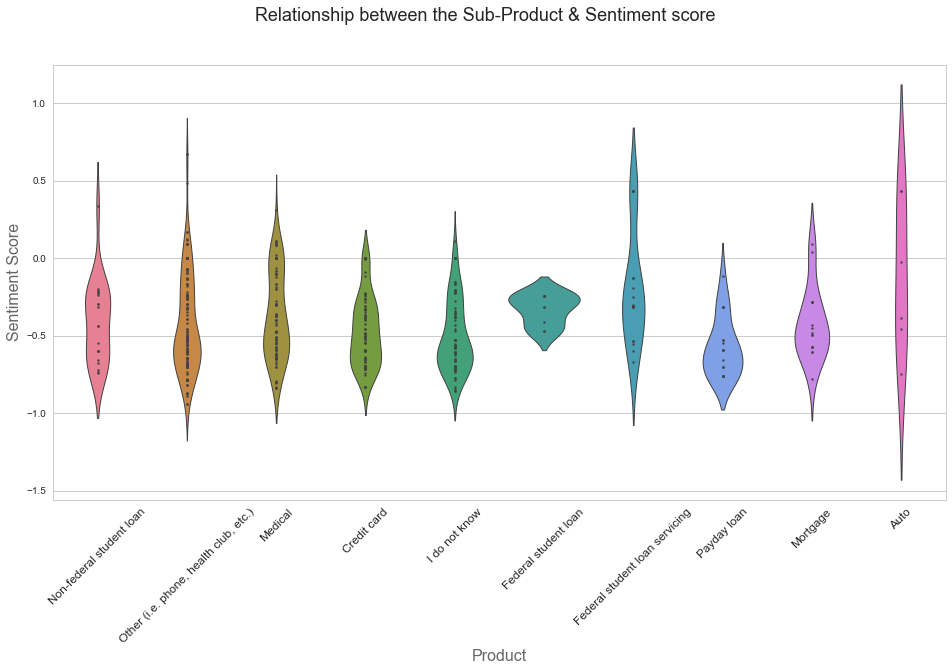

In [27]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(16, 8))

# Show each distribution with both violins and points
sns.violinplot(x="Sub-product",y="TextOverallSentimentScore", data=df, 
               palette="husl", inner="points", linewidth=1)

f.suptitle('Relationship between the Sub-Product & Sentiment score', fontsize=18)
ax.set_xlabel("Product", size = 16, alpha=0.7)
ax.set_ylabel("Sentiment Score", size = 16, alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### What is the distribution of sentiment type and emotion by month across all years?
A swarm plot that is used below is used to represent a categorical scatterplot with non-overlapping points. This gives a better representation of the distribution of Predominant Emotion Score values.

A swarm plot can be drawn on its own, but it is also a good complement to a box or violin plot in cases where you want to show all observations along with some representation of the underlying distribution.

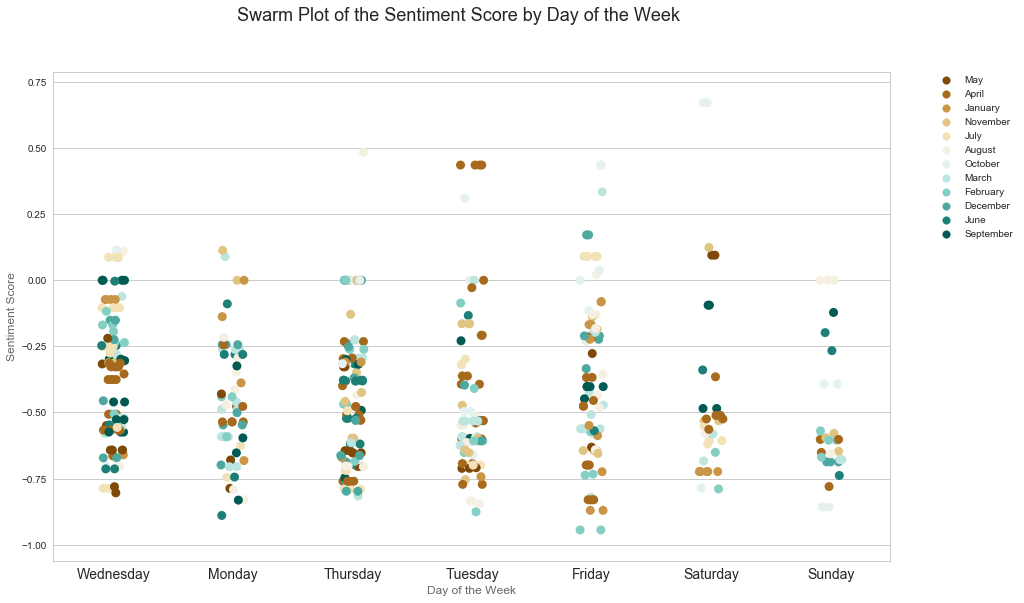

In [28]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()
sns.stripplot(x=df["Date received DoW"], y=df["TextOverallSentimentScore"], data=df, 
              jitter=True, hue=df["Date received MoY"], palette="BrBG", size=9);

# set the chart title, size and axis labels
fig.set_size_inches(15, 9)
fig.suptitle('Swarm Plot of the Sentiment Score by Day of the Week', fontsize=18)
ax.set_xlabel("Day of the Week", size=12, alpha=0.7)
ax.set_ylabel("Sentiment Score", size=12, alpha=0.7)
plt.xticks(rotation=0, fontsize=14)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

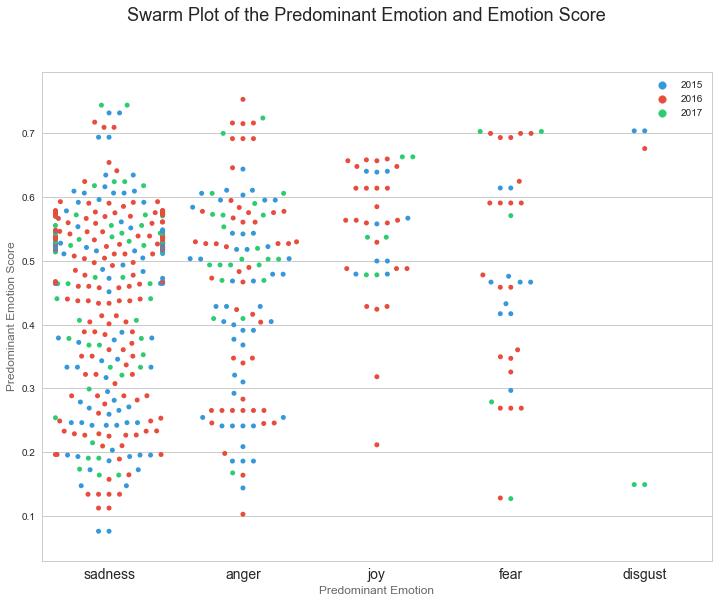

In [29]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()
flatui = ["#3498db", "#e74c3c", "#2ecc71"]

sns.swarmplot(x=df["TextHighestEmotion"], y=df["TextHighestEmotionScore"], hue=df["Date received Yr"], 
              data=df, palette=sns.color_palette(flatui));

# set the chart title, size and axis labels
fig.set_size_inches(12, 9)
fig.suptitle('Swarm Plot of the Predominant Emotion and Emotion Score', fontsize=18)
ax.set_xlabel("Predominant Emotion", size=12, alpha=0.7)
ax.set_ylabel("Predominant Emotion Score", size=12, alpha=0.7)
plt.xticks(rotation=0, fontsize=14)
plt.legend(loc='upper right')

<div style="text-align: right">[Back to the Visualization](#visualize)</div>

### Which companies had the highest negative sentiment scores?

In [30]:
# get only negative sentime type
df_only_neg = df.loc[df['TextOverallSentimentType'] == 'negative']

# Now sort by the TextOverallSentimentScore in descending order
groupby_company_sentiment = df_only_neg.sort_values('TextOverallSentimentScore', ascending=False)

# Get the top 10 companies
groupby_company_sentiment = groupby_company_sentiment.tail(10)

In [31]:
from IPython.display import display, HTML
display(HTML(groupby_company_sentiment[['Company', 'Product', 'Issue', 'State', 'TextOverallSentimentScore', 
                                        'Submitted via']].to_html(index=False)))

<div style="text-align: right">[Back to the top](#toc)</div>

### How are the columns/features correlated?

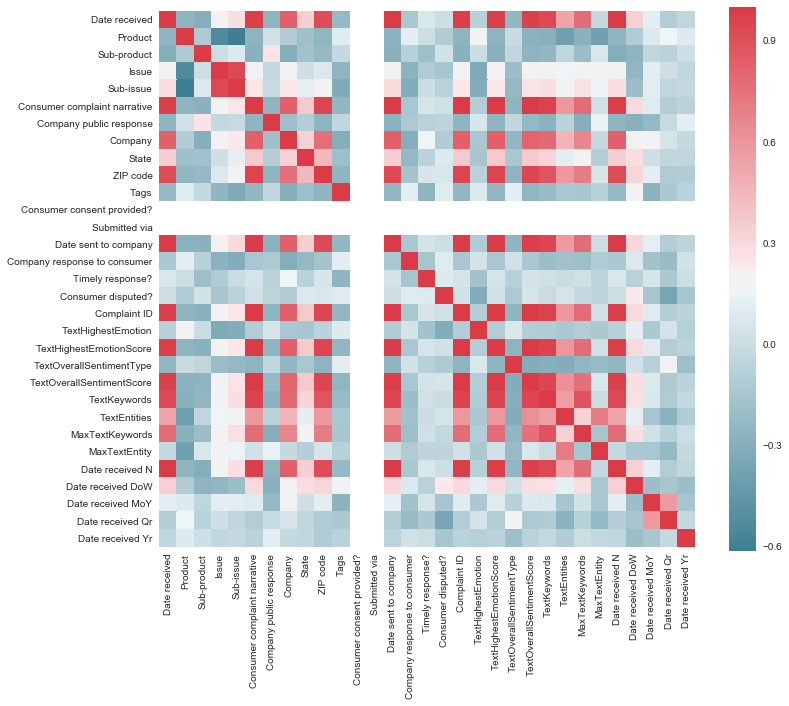

In [32]:
dfcorr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

f, ax = plt.subplots(figsize=(12, 10))
corr = dfcorr.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<div style="text-align: right">[Back to the top](#toc)</div>

## 7. Summary and Next Steps

> "Customer service is the new marketing." - Derek Sivers, Founder CD Baby

Needless to say, positive experiences lead to happy customers. But how can an enterprise know their customers are saying anb feeling through choice of words? Easier said than done, customer reviws, feedback and complainst etc requires a deeper understanding of what they are expressing as well as the surrounding context. We need AI systems like NLU and algorithms built around it to review them, come up with scores that are easily understandable form and supported by evidence. This easily accessible information will aid enterprises from making informed decisions, act on issues with customers, serve their customers better and in the end leading to satified clients. Having said so, some of the other things you could do and try include,

- Import the enriched CSV into your favorite business intelligence (BI) tool and perform further descriptive & statistical analysis.
- Use the Watson NLU enriched features as part of a predictive model you may already have.
- Build a customer churn scoring model.
- Build a predictive ML model to predict if a given customer complaint is fake given the set of feature vectors chosen including Watson NLU provided.